In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.utils import shuffle
from keras.preprocessing import image
import cv2
import tensorflow as tf
from PIL import Image
from sklearn.metrics import accuracy_score
import re
import random

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
from tensorflow.keras.preprocessing import image

In [19]:
data_directory = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\garbage_classification"

In [20]:
subfolders = os.listdir(data_directory)
random_subfolder = random.choice(subfolders)
subfolder_path = os.path.join(data_directory, random_subfolder)

random_file = random.choice(os.listdir(subfolder_path))

image_path = os.path.join(subfolder_path, random_file)
random_image = image.load_img(image_path)
print('Image path:', image_path)
plt.imshow(random_image)
plt.show()


ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [6]:
garbage_types_labels = {
    'battery': 'battery',
    'biological': 'biological',
    'brown-glass': 'brown-glass',
    'cardboard': 'cardboard',
    'clothes': 'clothes',
    'green-glass': 'green-glass',
    'metal': 'metal',
    'paper': 'paper',
    'plastic': 'plastic',
    'shoes': 'shoes',
    'trash': 'trash',
    'white-glass': 'white-glass'
}


Hereby we are going to create a dataframe with with each photo:
- We create a list (filenames_list) with all the filenames in the dataset.
- We create a list to store the corresponding category (categories_list). To take into account that each folder of the dataset has one class of data
- We do a for loop with all the files on the folders to loop each element of the dictionary with all our garbage types. The loop obtains the name slist of each file and store them in (filenames). The same for categories (categories_list) storages the list of categories as much of times that the categories is present in the files.
- Then, we create the df wit two columns 'Image'and'Garbage_category'.
- Finally, we create a fx (def file_rename) to create a prefix to each file. This will help us in the next steps to model and analyse each file.

In [7]:
# list containing all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for item in garbage_types_labels:
    filenames = os.listdir(data_directory + "/" + str(garbage_types_labels[item]))
    
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [item] * len(filenames)
    
df = pd.DataFrame({
    'Image': filenames_list,
    'Category': categories_list
})
df

,Image,Category
0,battery1.jpg,battery
1,battery10.jpg,battery
2,battery100.jpg,battery
3,battery101.jpg,battery
4,battery102.jpg,battery
...,...,...
15510,white-glass95.jpg,white-glass
15511,white-glass96.jpg,white-glass
15512,white-glass97.jpg,white-glass
15513,white-glass98.jpg,white-glass


In [8]:
def file_rename(df, col_name):
    df[col_name] = df[col_name].astype(str).apply(lambda x: x[:re.search("\d", str(x)).start()] + '/' + str(x))
    return df


In [9]:
df=file_rename(df, 'Image')
df['Image'][0]

'battery/battery1.jpg'

In [10]:
df['Image'] = df['Image'].apply(lambda x: data_directory + '/' + x)

In [11]:
df

,Image,Category
0,C:\Users\Leticia Martinez\Desktop\IRONHACK\Lab...,battery
1,C:\Users\Leticia Martinez\Desktop\IRONHACK\Lab...,battery
2,C:\Users\Leticia Martinez\Desktop\IRONHACK\Lab...,battery
3,C:\Users\Leticia Martinez\Desktop\IRONHACK\Lab...,battery
4,C:\Users\Leticia Martinez\Desktop\IRONHACK\Lab...,battery
...,...,...
15510,C:\Users\Leticia Martinez\Desktop\IRONHACK\Lab...,white-glass
15511,C:\Users\Leticia Martinez\Desktop\IRONHACK\Lab...,white-glass
15512,C:\Users\Leticia Martinez\Desktop\IRONHACK\Lab...,white-glass
15513,C:\Users\Leticia Martinez\Desktop\IRONHACK\Lab...,white-glass


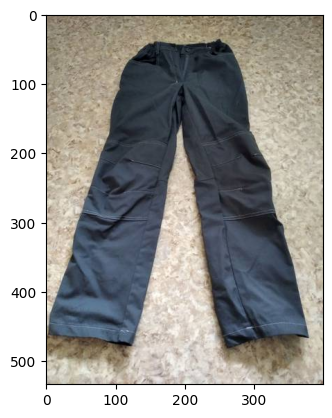

In [12]:
random_row = random.randint(0, len(df) - 1)
sample = df.iloc[random_row]
image_path = os.path.join(data_directory, sample['Image'])
random_image = image.load_img(image_path)
plt.imshow(random_image)
plt.show()

In [13]:
duplicates_exist = df.duplicated().any()
print(duplicates_exist)

False


In [14]:
nulls=df.isnull().any()
print(nulls)

Image       False
Category    False
dtype: bool


In [15]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(12412, 1551, 1552)

In [16]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv',index=False)
val_df.to_csv('validation.csv',index=False)

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0

num_classes=12

# Definir parámetros de la red
img_height = 224
img_width = 224
batch_size = 1
epochs = 1

# Crear generadores de imágenes para el preprocesamiento y aumento de datos
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
# Generar datos de entrenamiento y prueba utilizando los generadores de imágenes
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image',
    y_col='Category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 9930 validated image filenames belonging to 12 classes.


In [20]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Image',
    y_col='Category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 310 validated image filenames belonging to 12 classes.


In [21]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image',
    y_col='Category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1552 validated image filenames belonging to 12 classes.


In [22]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [23]:
# Agregar capas adicionales al modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Definir el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

# Evaluar el modelo en el conjunto de prueba


9930/9930 [==============================] - 1005s 100ms/step - loss: 0.3372 - accuracy: 0.9067 - val_loss: 0.2939 - val_accuracy: 0.9387


In [27]:
model.save("data/cnn_model.h5")

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [41]:
!conda install tensorflow==2.9

Retrieving notices: ...working... done
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.



PackagesNotFoundError: The following packages are not available from current channels:

  - tensorflow==2.9

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [ ]:
!pip install --upgrade tensorflow==2.9

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0

In [ ]:
model.evaluate(test_generator)

In [33]:
import json
import numpy as np

# Supongamos que `eager_tensor` es el objeto EagerTensor que quieres guardar
eager_tensor = np.array([2.0896919, 2.1128857, 2.1081853])
values = eager_tensor.tolist()

# Guardar los valores en un archivo JSON
with open('valores.json', 'w') as file:
    json.dump(values, file)

In [35]:
from tensorflow.keras.models import load_model

In [36]:
loaded_model = load_model('modelo.h5')

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000001B8018A8970>.

In [37]:
!ls

Eurostat.ipynb
ML_classification-Copy1.ipynb
ML_classification-Copy2.ipynb
ML_classification-Copy3.ipynb
ML_classification-Copy4.ipynb
ML_classification-model2-Copy1.ipynb
ML_classification-model2.ipynb
ML_classification.ipynb
datasets
eurostat.xlsx
garbage_classification
model_pre_98
modelo.h5
ols
photo_test
project.ipynb
test.csv
train.csv
validation.csv
valores.json


In [66]:
# Evaluation of the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print("Loss on the test set:", loss)
print("Accurancy on the test set:", accuracy)


313/313 [==============================] - 4s 12ms/step - loss: 0.0630 - accuracy: 0.9847
Loss on the test set: 0.0630066990852356
Accurancy on the test set: 0.9847000241279602


In [67]:
predictions = model.predict(X_test)

313/313 [==============================] - 4s 11ms/step


In [68]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9847


In [69]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_mtx)


Confusion Matrix:
[[ 972    0    2    0    1    0    1    1    3    0]
 [   1 1123    5    1    0    0    2    1    2    0]
 [   1    2 1013    1    1    0    0    5    9    0]
 [   0    0    2  995    0    6    0    3    4    0]
 [   0    0    2    0  971    0    2    0    0    7]
 [   1    0    1    6    0  880    3    0    1    0]
 [   5    2    3    0    1    1  944    0    2    0]
 [   0    1   12    0    0    0    0 1009    5    1]
 [   3    0    2    0    1    0    1    4  961    2]
 [   2    3    0    5    9    3    0    3    5  979]]


In [75]:
import numpy as np
from PIL import Image

image_path = r"C:\Users\Leticia Martinez\Desktop\IRONHACK\Labs\Project_V\IMG-8644.jpg"
image = Image.open(image_path).convert('L')  # Convertir a escala de grises si es necesario
image = image.resize((28, 28))  # Redimensionar a 28x28 píxeles si es necesario
image = np.array(image)
image = image.reshape(1, 28, 28, 1)  # Agregar dimensión adicional para el batch

# Normalizar la imagen
image = image.astype('float32')
image /= 255

# Realizar la predicción
predictions = model.predict(image)

# Obtener la clase con mayor probabilidad
predicted_class = np.argmax(predictions)

print("La imagen es:", predicted_class)


1/1 [==============================] - 0s 74ms/step
La imagen es: 2
